In [5]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage import exposure
import pywt
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.models import load_model
import random
import cv2
from sklearn.model_selection import train_test_split

Annotations file exists: True
Candidates file exists: True
Segmentation directory exists: True
Subset0 directory exists: True
Subset1 directory exists: True
Subset2 directory exists: True
Subset3 directory exists: True
Subset4 directory exists: True
Processing subset0...
Processing subset1...
Processing subset2...
Processing subset3...
Processing subset4...
Dataset prepared with 780 positive and 2831 negative samples
Train: 2527, Validation: 542, Test: 542


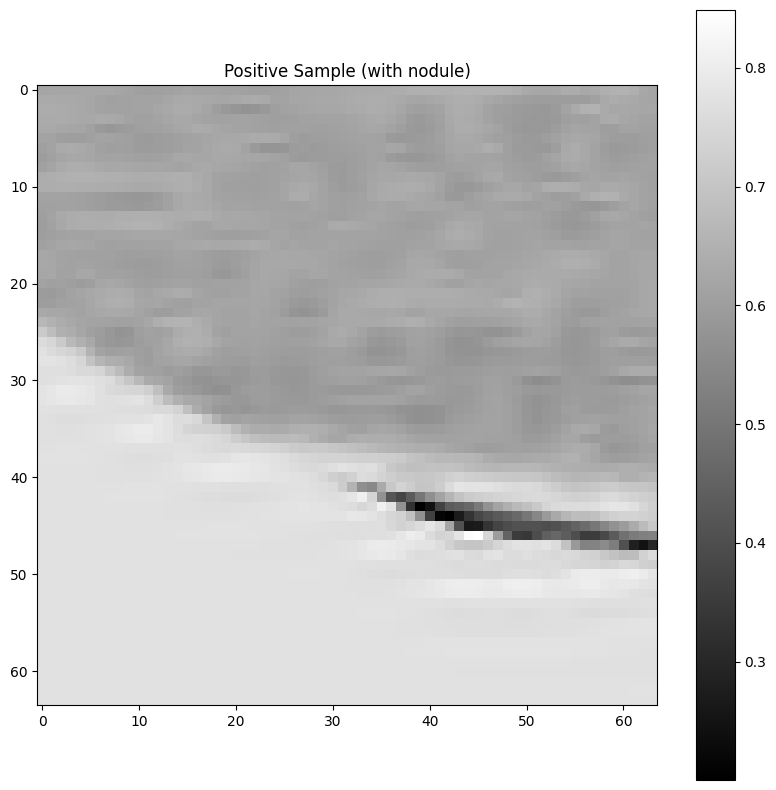

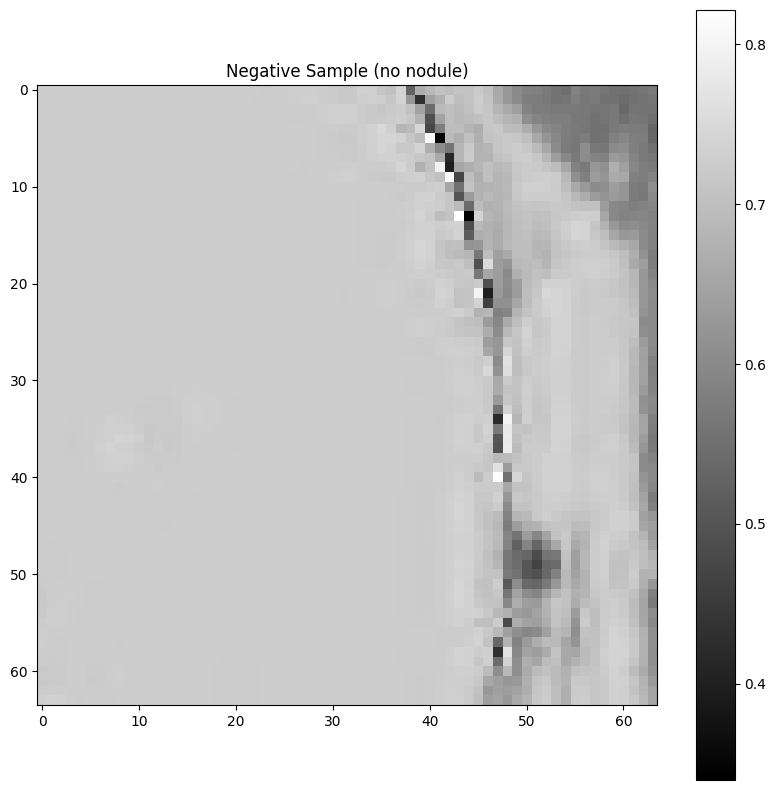

Preprocessing, enhancement, and augmentation complete!


In [6]:
# Define paths
BASE_DIR = '/workspace/deep_learning_luna16/luna16_dataset'  # Update with your path
ANNOTATIONS_PATH = os.path.join(BASE_DIR, 'annotations.csv')
CANDIDATES_PATH = os.path.join(BASE_DIR, 'candidates.csv')
SEGMENTATION_PATH = os.path.join(BASE_DIR, 'seg-lungs-LUNA16/seg-lungs-LUNA16')
SUBSET_PATHS = [os.path.join(BASE_DIR, f'subset{i}/subset{i}') for i in range(5)]

# Check if paths exist
print(f"Annotations file exists: {os.path.exists(ANNOTATIONS_PATH)}")
print(f"Candidates file exists: {os.path.exists(CANDIDATES_PATH)}")
print(f"Segmentation directory exists: {os.path.exists(SEGMENTATION_PATH)}")
for i, path in enumerate(SUBSET_PATHS):
    print(f"Subset{i} directory exists: {os.path.exists(path)}")

def load_scan(path):
    """Load CT scan from .mhd file"""
    itk_img = sitk.ReadImage(path)
    img_array = sitk.GetArrayFromImage(itk_img)
    origin = np.array(itk_img.GetOrigin())
    spacing = np.array(itk_img.GetSpacing())
    return img_array, origin, spacing, itk_img

def normalize_hu(image, min_bound=-1000, max_bound=400):
    """Normalize HU values to [0,1] range with lung window"""
    image = np.clip(image, min_bound, max_bound)
    image = (image - min_bound) / (max_bound - min_bound)
    return image

def standardize_spacing(image, spacing, new_spacing=[1.0, 1.0, 1.0]):
    """Standardize the spacing of the CT scan"""
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    real_resize_factor = new_shape / image.shape
    
    new_img = ndimage.zoom(image, real_resize_factor, mode='nearest')
    return new_img

def wavelet_enhancement(image, wavelet='db4', level=2, threshold_factor=1.0):
    """Enhance the image using wavelet decomposition"""
    enhanced = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        slice_2d = image[i]
        # Wavelet decomposition
        coeffs = pywt.wavedec2(slice_2d, wavelet, level=level)
        
        # Modify the detail coefficients (high frequency components)
        coeffs_modified = [coeffs[0]]  # Keep approximation coefficients as-is
        for j in range(1, len(coeffs)):
            # Each coeffs[j] is a tuple (Horizontal, Vertical, Diagonal)
            cH, cV, cD = coeffs[j]
            threshold_H = threshold_factor * np.std(cH)
            threshold_V = threshold_factor * np.std(cV)
            threshold_D = threshold_factor * np.std(cD)
            cH = pywt.threshold(cH, threshold_H, mode='soft')
            cV = pywt.threshold(cV, threshold_V, mode='soft')
            cD = pywt.threshold(cD, threshold_D, mode='soft')
            coeffs_modified.append((cH, cV, cD))  # Repack into a tuple
        
        # Reconstruct the image
        enhanced_slice = pywt.waverec2(coeffs_modified, wavelet)
        
        # In case the reconstructed slice size is slightly off due to padding
        enhanced[i] = enhanced_slice[:slice_2d.shape[0], :slice_2d.shape[1]]
    
    # Normalize to [0,1]
    enhanced = (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min() + 1e-8)
    return enhanced


def get_nodule_info():
    """Get nodule information from annotations.csv"""
    annotations = pd.read_csv(ANNOTATIONS_PATH)
    nodules = {}
    
    for _, row in annotations.iterrows():
        seriesuid = row['seriesuid']
        coord_x = row['coordX']
        coord_y = row['coordY']
        coord_z = row['coordZ']
        diameter_mm = row['diameter_mm']
        
        if seriesuid not in nodules:
            nodules[seriesuid] = []
        
        nodules[seriesuid].append({
            'coord_x': coord_x,
            'coord_y': coord_y,
            'coord_z': coord_z,
            'diameter_mm': diameter_mm
        })
    
    return nodules

def world_to_voxel(world_coords, origin, spacing):
    """Convert world coordinates to voxel coordinates"""
    voxel_coords = np.round((world_coords - origin) / spacing).astype(int)
    return voxel_coords

def extract_patches(image, center, diameter, patch_size=64):
    """Extract patches centered around nodules"""
    radius = int(diameter / 2)
    patch_radius = patch_size // 2
    
    # Get bounds
    z_min = max(0, center[0] - patch_radius)
    y_min = max(0, center[1] - patch_radius)
    x_min = max(0, center[2] - patch_radius)
    
    z_max = min(image.shape[0], center[0] + patch_radius)
    y_max = min(image.shape[1], center[1] + patch_radius)
    x_max = min(image.shape[2], center[2] + patch_radius)
    
    # Extract patch
    patch = np.zeros((patch_size, patch_size, patch_size))
    extract = image[z_min:z_max, y_min:y_max, x_min:x_max]
    
    # Place extract in the patch (handling edge cases)
    z_extract, y_extract, x_extract = extract.shape
    patch[:z_extract, :y_extract, :x_extract] = extract
    
    return patch

import numpy as np
import random
from scipy import ndimage
from skimage import exposure

def autoaugment_3d(patch):
    """Apply a simplified and safer version of AutoAugment to 3D patches."""
    augmented = patch.copy()
    
    # ✨ Clip before starting (to handle any small negatives from preprocessing)
    augmented = np.clip(augmented, 0, 1)
    
    # Randomly select 1 to 3 augmentations
    operations = random.sample(
        ['rotate', 'flip', 'translate', 'noise', 'contrast', 'identity'],
        k=random.randint(1, 3)
    )
    
    for op in operations:
        if op == 'rotate':
            # Random rotation angle (small)
            angle = random.uniform(-20, 20)
            for i in range(augmented.shape[0]):  # Rotate each 2D slice
                augmented[i] = ndimage.rotate(augmented[i], angle, reshape=False, mode='nearest')
                
        elif op == 'flip':
            # Random flip along any axis
            flip_axis = random.randint(0, 2)
            augmented = np.flip(augmented, axis=flip_axis)
            
        elif op == 'translate':
            # Random shift along each axis
            shift = [random.randint(-5, 5) for _ in range(3)]
            augmented = ndimage.shift(augmented, shift, mode='nearest')
            
        elif op == 'noise':
            # Add Gaussian noise
            noise = np.random.normal(0, 0.02, size=augmented.shape)
            augmented = np.clip(augmented + noise, 0, 1)
            
        elif op == 'contrast':
            # Random contrast adjustment
            # ✨ Important: Clip to [0,1] before contrast adjustment
            augmented = np.clip(augmented, 0, 1)
            gamma = random.uniform(0.8, 1.2)
            augmented = exposure.adjust_gamma(augmented, gamma)
        
        elif op == 'identity':
            # Do nothing (keep the original patch)
            pass
    
    # ✨ Final safety: make sure final augmented is in [0,1]
    augmented = np.clip(augmented, 0, 1)
    
    return augmented


def medmix_augmentation(patch, mask, alpha=0.5):
    """Apply MedMix augmentation to patches"""
    # For simplicity, we'll assume the mask is binary (1s where nodule is)
    # In a real implementation, you'd have accurate segmentation masks
    
    # Get another random patch (would be from another sample in practice)
    # Here we'll just use a slightly modified version of the original
    other_patch = patch * 0.9 + np.random.normal(0, 0.1, patch.shape)
    
    # MedMix: Keep the region of interest from the original
    # and mix the background with the other patch
    mixed_patch = mask * patch + (1 - mask) * (alpha * patch + (1 - alpha) * other_patch)
    
    return mixed_patch

def prepare_dataset():
    """Main function to prepare the dataset"""
    # Get nodule information
    nodules_info = get_nodule_info()
    
    X_positive = []  # Patches with nodules
    X_negative = []  # Patches without nodules
    
    # Process each subset
    for subset_dir in SUBSET_PATHS:
        subset_name = os.path.basename(subset_dir)
        print(f"Processing {subset_name}...")
        
        # Get all .mhd files in the subset
        for root, _, files in os.walk(subset_dir):
            for file in files:
                if file.endswith('.mhd'):
                    file_path = os.path.join(root, file)
                    series_id = file.split('.mhd')[0]
                    
                    # Check if this series has nodules
                    if series_id in nodules_info:
                        # Load the scan
                        img_array, origin, spacing, _ = load_scan(file_path)
                        
                        # Step 1: Preprocessing
                        # Load segmentation mask (if available)
                        seg_path = os.path.join(SEGMENTATION_PATH, f"{series_id}.npy")
                        if os.path.exists(seg_path):
                            lung_mask = np.load(seg_path)
                        else:
                            # If segmentation not available, use a simple threshold
                            lung_mask = (img_array > -400) & (img_array < 0)
                        
                        # Apply lung mask and normalize
                        img_array = img_array * lung_mask
                        img_array = normalize_hu(img_array)
                        
                        # Standardize spacing
                        img_array = standardize_spacing(img_array, spacing)
                        
                        # Step 2: Enhancement using wavelet decomposition
                        enhanced_img = wavelet_enhancement(img_array)
                        
                        # Extract positive patches (around nodules)
                        for nodule in nodules_info[series_id]:
                            world_coords = np.array([nodule['coord_z'], nodule['coord_y'], nodule['coord_x']])
                            voxel_coords = world_to_voxel(world_coords, origin, spacing)
                            
                            # Make sure coordinates are within image bounds
                            if (0 <= voxel_coords[0] < img_array.shape[0] and
                                0 <= voxel_coords[1] < img_array.shape[1] and
                                0 <= voxel_coords[2] < img_array.shape[2]):
                                
                                # Extract patch around nodule
                                patch = extract_patches(enhanced_img, voxel_coords, 
                                                       nodule['diameter_mm'], patch_size=64)
                                
                                # Create a simple spherical mask for the nodule (approximate)
                                mask = np.zeros_like(patch)
                                center = np.array(patch.shape) // 2
                                for z in range(patch.shape[0]):
                                    for y in range(patch.shape[1]):
                                        for x in range(patch.shape[2]):
                                            dist = np.sqrt(((z-center[0])**2 + (y-center[1])**2 + (x-center[2])**2))
                                            if dist <= nodule['diameter_mm'] / 2:
                                                mask[z, y, x] = 1
                                
                                # Step 3: Augmentation
                                # Store original
                                X_positive.append(patch)
                                
                                # Generate augmented versions
                                for _ in range(3):  # Create 3 augmented samples per nodule
                                    aug_patch = autoaugment_3d(patch)
                                    X_positive.append(aug_patch)
                                
                                # Apply MedMix augmentation
                                medmix_patch = medmix_augmentation(patch, mask)
                                X_positive.append(medmix_patch)
                        
                        # Extract some negative patches (regions without nodules)
                        # This is a simplified approach - in practice you'd want to be more selective
                        for _ in range(min(len(nodules_info[series_id]) * 5, 20)):
                            # Random position (away from nodules)
                            z = random.randint(32, img_array.shape[0] - 32)
                            y = random.randint(32, img_array.shape[1] - 32)
                            x = random.randint(32, img_array.shape[2] - 32)
                            
                            # Make sure it's far from any nodule
                            is_far = True
                            for nodule in nodules_info[series_id]:
                                world_coords = np.array([nodule['coord_z'], nodule['coord_y'], nodule['coord_x']])
                                voxel_coords = world_to_voxel(world_coords, origin, spacing)
                                
                                dist = np.sqrt((z - voxel_coords[0])**2 + 
                                              (y - voxel_coords[1])**2 + 
                                              (x - voxel_coords[2])**2)
                                
                                if dist < 50:  # Arbitrary distance threshold
                                    is_far = False
                                    break
                            
                            if is_far:
                                center = np.array([z, y, x])
                                patch = extract_patches(enhanced_img, center, 20, patch_size=64)
                                X_negative.append(patch)
    
    # Convert to numpy arrays
    X_positive = np.array(X_positive)
    X_negative = np.array(X_negative)
    
    # Create labels
    y_positive = np.ones(len(X_positive))
    y_negative = np.zeros(len(X_negative))
    
    # Combine datasets
    X = np.concatenate([X_positive, X_negative], axis=0)
    y = np.concatenate([y_positive, y_negative], axis=0)
    
    # Shuffle
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Split into train/val/test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Dataset prepared with {len(X_positive)} positive and {len(X_negative)} negative samples")
    print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def visualize_sample(image, title="Sample"):
    """Visualize middle slice of a 3D volume"""
    middle_slice = image[image.shape[0]//2]
    plt.figure(figsize=(10, 10))
    plt.imshow(middle_slice, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

if __name__ == "__main__":
    # Update the base directory path
    BASE_DIR = '/workspace/deep_learning_luna16/luna16_dataset'  # Change this to your actual path
    
    # Prepare dataset
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()
    
    # Visualize some samples
    pos_idx = np.where(y_train == 1)[0][0]
    neg_idx = np.where(y_train == 0)[0][0]
    
    visualize_sample(X_train[pos_idx], "Positive Sample (with nodule)")
    visualize_sample(X_train[neg_idx], "Negative Sample (no nodule)")
    
    # Save preprocessed data
    np.save('X_train.npy', X_train)
    np.save('X_val.npy', X_val)
    np.save('X_test.npy', X_test)
    np.save('y_train.npy', y_train)
    np.save('y_val.npy', y_val)
    np.save('y_test.npy', y_test)
    
    print("Preprocessing, enhancement, and augmentation complete!")

Training data shape: (2527, 64, 64, 64, 1)
Validation data shape: (542, 64, 64, 64, 1)
Test data shape: (542, 64, 64, 64, 1)
Stage 1: Training with 25% of data...
Epoch 1/20


2025-04-26 15:32:23.622836: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2025-04-26 15:32:23.980230: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ff29004a180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-26 15:32:23.980293: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-26 15:32:23.980306: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-26 15:32:23.980317: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-26 15:32:23.980327: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-26 15:32:23.980338: I tensorflow/compiler/xla/service/service.cc:181]   StreamExec

79/79 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.8114 - precision: 0.7703 - recall: 0.3585 - auc: 0.7299
Epoch 1: val_auc improved from -inf to 0.50000, saving model to best_model.h5
79/79 [==============================] - 25s 217ms/step - loss: 0.0532 - accuracy: 0.8114 - precision: 0.7703 - recall: 0.3585 - auc: 0.7299 - val_loss: 0.1019 - val_accuracy: 0.7915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 3.0000e-04
Epoch 2/20
79/79 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.8780 - precision: 0.9457 - recall: 0.5472 - auc: 0.8500
Epoch 2: val_auc did not improve from 0.50000
79/79 [==============================] - 11s 140ms/step - loss: 0.0346 - accuracy: 0.8780 - precision: 0.9457 - recall: 0.5472 - auc: 0.8500 - val_loss: 0.1241 - val_accuracy: 0.7915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 3.0000e-04
Epoch 3/20
79/79 [==============================] - ETA

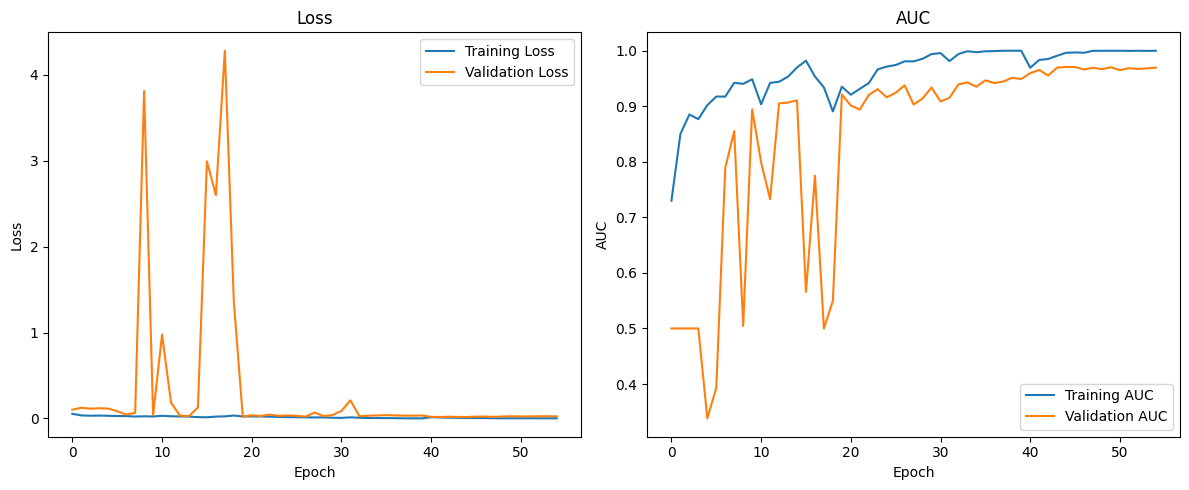


Evaluating on test set...
17/17 [==============================] - 7s 236ms/step
AUC-ROC: 0.9389
Clinical threshold: 0.0624
Sensitivity at clinical threshold: 0.9569
Specificity at clinical threshold: 0.5141
Number of false negatives: 6


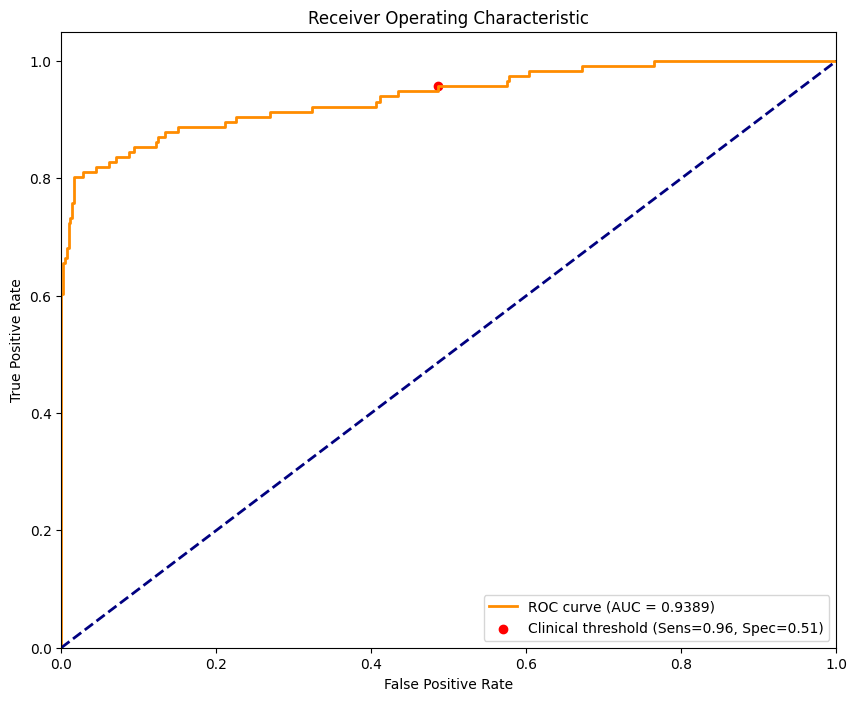

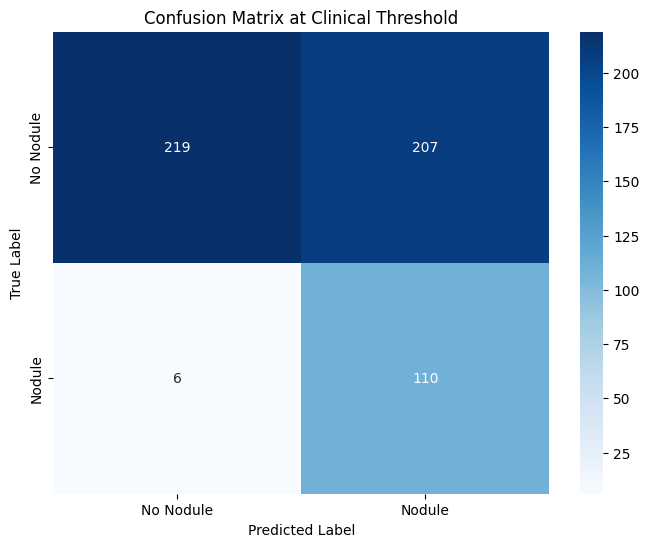

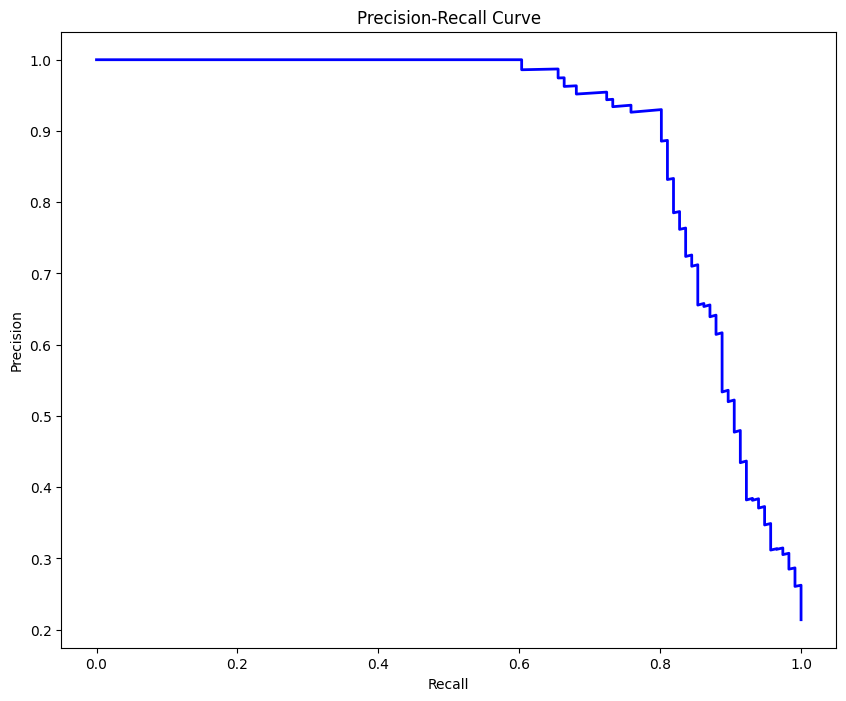

17/17 [==============================] - 2s 83ms/step
Analyzing 6 false negative cases...


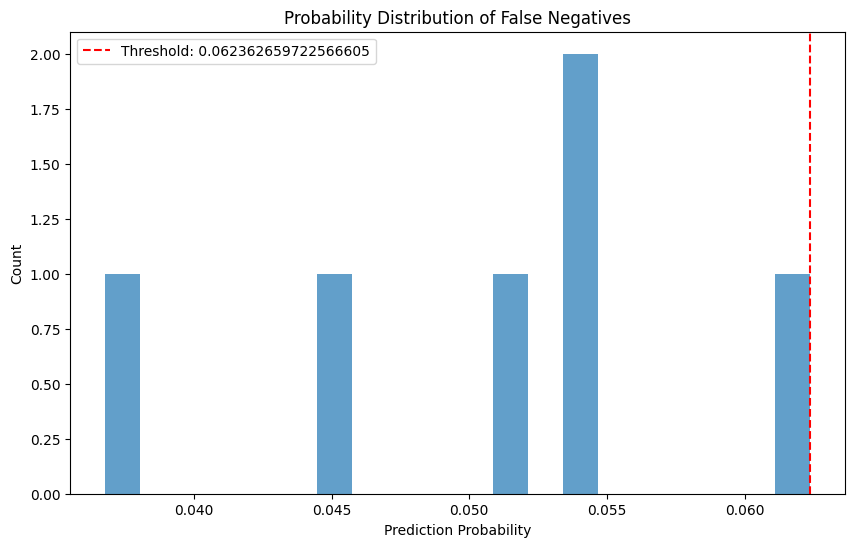

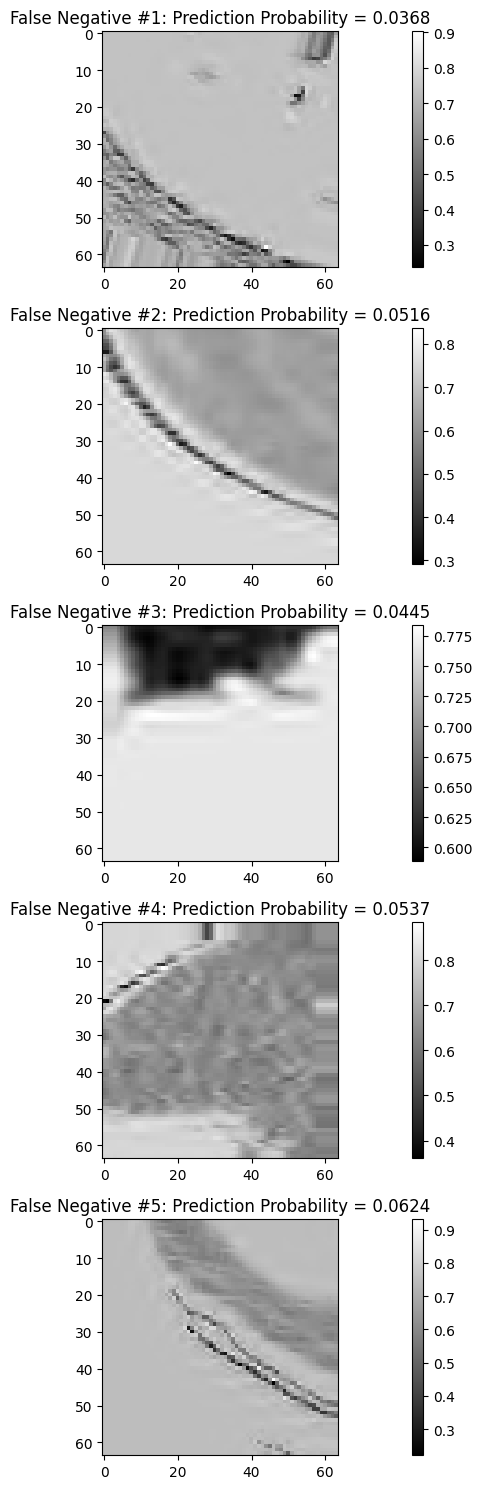

Results saved to results

Training and evaluation complete!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import pandas as pd
import seaborn as sns
import os

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def focal_loss(gamma=2., alpha=.25):
    """Focal loss for addressing class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        
        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

from tensorflow.keras import layers

from tensorflow.keras import layers

def efficient_3d_block(x, filters, kernel_size=3, stride=1, expand_ratio=1, se_ratio=0.25, activation='swish'):
    shortcut = x
    input_channels = x.shape[-1]
    expanded_channels = input_channels * expand_ratio

    # Expansion phase
    if expand_ratio != 1:
        x = layers.Conv3D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

    # "Depthwise" convolution using groups
    x = layers.Conv3D(
        expanded_channels, 
        kernel_size=kernel_size, 
        strides=stride, 
        padding='same', 
        use_bias=False, 
        groups=expanded_channels
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Squeeze and Excitation
    if se_ratio > 0:
        se_channels = max(1, int(input_channels * se_ratio))
        se = layers.GlobalAveragePooling3D()(x)
        se = layers.Reshape((1, 1, 1, expanded_channels))(se)
        se = layers.Conv3D(se_channels, kernel_size=1, activation=activation, padding='same')(se)
        se = layers.Conv3D(expanded_channels, kernel_size=1, activation='sigmoid', padding='same')(se)
        x = layers.Multiply()([x, se])

    # Projection phase
    x = layers.Conv3D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if stride == 1 and input_channels == filters:
        x = layers.Add()([shortcut, x])

    return x


def transformer_encoder_block(x, embed_dim, num_heads, ff_dim, dropout=0.1):
    """Transformer encoder block for global context modeling"""
    # Multi-head attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim // num_heads)(x, x)
    attention_output = layers.Dropout(dropout)(attention_output)
    x1 = layers.Add()([x, attention_output])
    x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
    
    # Feed-forward network
    ffn_output = layers.Dense(ff_dim, activation='relu')(x1)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    x2 = layers.Add()([x1, ffn_output])
    out = layers.LayerNormalization(epsilon=1e-6)(x2)
    
    return out

def build_model(input_shape=(64, 64, 64, 1), base_filters=32):
    """Build the hybrid CNN-Transformer model for lung nodule detection"""
    inputs = layers.Input(shape=input_shape)
    
    # Initial Conv
    x = layers.Conv3D(base_filters, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Progressive complexity - EfficientNet-style blocks
    # Block 1
    x = efficient_3d_block(x, base_filters)
    x = layers.MaxPooling3D(pool_size=2)(x)
    
    # Block 2
    x = efficient_3d_block(x, base_filters * 2)
    x = efficient_3d_block(x, base_filters * 2)
    x = layers.MaxPooling3D(pool_size=2)(x)
    
    # Block 3
    x = efficient_3d_block(x, base_filters * 4)
    x = efficient_3d_block(x, base_filters * 4)
    x = layers.MaxPooling3D(pool_size=2)(x)
    
    # Block 4
    x = efficient_3d_block(x, base_filters * 8)
    x = efficient_3d_block(x, base_filters * 8)
    
    # Transformer for global context
    # Reshape for transformer
    batch_size = tf.shape(x)[0]
    h_dim = tf.shape(x)[1]
    w_dim = tf.shape(x)[2]
    d_dim = tf.shape(x)[3]
    c_dim = tf.shape(x)[4]
    
    # Flatten spatial dimensions for transformer
    x_reshaped = tf.reshape(x, [batch_size, h_dim * w_dim * d_dim, c_dim])
    
    # Apply transformer blocks
    transformer_dim = base_filters * 8
    x_transformed = transformer_encoder_block(
        x_reshaped, embed_dim=transformer_dim,
        num_heads=4, ff_dim=transformer_dim * 4, dropout=0.1
    )
    
    # Global pooling after transformer
    x_pooled = layers.GlobalAveragePooling1D()(x_transformed)
    
    # Classification head
    x = layers.Dense(256, activation='relu')(x_pooled)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Output with uncertainty (logits)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, output)
    return model

def train_model(X_train, y_train, X_val, y_val, batch_size=16, epochs=50, lr=0.001):
    """Train the model with progressive learning strategy"""
    # Reshape data to include channel dimension if needed
    if len(X_train.shape) == 4:
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
    
    # Build model
    model = build_model(input_shape=X_train.shape[1:])
    
    # Compile with focal loss
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                 tf.keras.metrics.AUC()]
    )
    
    # Setup callbacks
    checkpoint = ModelCheckpoint(
        'best_model.h5', monitor='val_auc', verbose=1, 
        save_best_only=True, mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_auc', patience=10, verbose=1, mode='max',
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, verbose=1,
        min_lr=1e-6
    )
    
    callbacks = [checkpoint, early_stopping, reduce_lr]
    
    # Progressive learning - start with small subset and gradually increase
    # Stage 1: 25% of data
    print("Stage 1: Training with 25% of data...")
    idx = np.random.choice(len(X_train), size=int(len(X_train)*0.25), replace=False)
    history_1 = model.fit(
        X_train[idx], y_train[idx],
        batch_size=batch_size,
        epochs=int(epochs/3),
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Stage 2: 50% of data
    print("Stage 2: Training with 50% of data...")
    idx = np.random.choice(len(X_train), size=int(len(X_train)*0.5), replace=False)
    history_2 = model.fit(
        X_train[idx], y_train[idx],
        batch_size=batch_size,
        epochs=int(epochs/3),
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Stage 3: 100% of data
    print("Stage 3: Training with 100% of data...")
    history_3 = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=int(epochs/3),
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Combine histories
    combined_history = {}
    for key in history_1.history.keys():
        combined_history[key] = (
            history_1.history[key] + 
            history_2.history[key] + 
            history_3.history[key]
        )
    
    return model, combined_history

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance with clinical metrics"""
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Find clinical thresholds (high sensitivity)
    # Aim for > 95% sensitivity for cancer detection
    target_sensitivity = 0.95
    idx = np.argmax(tpr >= target_sensitivity)
    clinical_threshold = thresholds[idx]
    clinical_sensitivity = tpr[idx]
    clinical_specificity = 1 - fpr[idx]
    
    # Apply clinical threshold
    y_pred_clinical = (y_pred_prob > clinical_threshold).astype(int).flatten()
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_clinical)
    
    # False negative analysis
    false_negatives = np.where((y_test == 1) & (y_pred_clinical == 0))[0]
    
    # Print metrics
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Clinical threshold: {clinical_threshold:.4f}")
    print(f"Sensitivity at clinical threshold: {clinical_sensitivity:.4f}")
    print(f"Specificity at clinical threshold: {clinical_specificity:.4f}")
    print(f"Number of false negatives: {len(false_negatives)}")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[idx], tpr[idx], marker='o', color='red', 
                label=f'Clinical threshold (Sens={clinical_sensitivity:.2f}, Spec={clinical_specificity:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Nodule', 'Nodule'],
                yticklabels=['No Nodule', 'Nodule'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix at Clinical Threshold')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('precision_recall_curve.png')
    plt.show()
    
    return {
        'auc_roc': roc_auc,
        'clinical_threshold': clinical_threshold,
        'sensitivity': clinical_sensitivity,
        'specificity': clinical_specificity,
        'false_negatives': len(false_negatives)
    }

def cross_dataset_validation(model, external_datasets):
    """Validate model on external datasets to test generalizability"""
    results = {}
    
    for dataset_name, (X, y) in external_datasets.items():
        print(f"\nEvaluating on external dataset: {dataset_name}")
        
        # Reshape if needed
        if len(X.shape) == 4:
            X = np.expand_dims(X, axis=-1)
        
        # Predict and evaluate
        metrics = evaluate_model(model, X, y)
        results[dataset_name] = metrics
    
    # Compare performance across datasets
    datasets = list(results.keys())
    aucs = [results[d]['auc_roc'] for d in datasets]
    sensitivities = [results[d]['sensitivity'] for d in datasets]
    specificities = [results[d]['specificity'] for d in datasets]
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    x = np.arange(len(datasets))
    width = 0.25
    
    plt.bar(x - width, aucs, width, label='AUC-ROC')
    plt.bar(x, sensitivities, width, label='Sensitivity')
    plt.bar(x + width, specificities, width, label='Specificity')
    
    plt.ylabel('Score')
    plt.title('Performance Across Datasets')
    plt.xticks(x, datasets)
    plt.legend()
    plt.savefig('cross_dataset_performance.png')
    plt.show()
    
    return results

def plot_training_history(history):
    """Plot training metrics history"""
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot AUC
    plt.subplot(1, 2, 2)
    plt.plot(history['auc'], label='Training AUC')
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def analyze_false_negatives(model, X_test, y_test, threshold=0.5):
    """Analyze false negative cases which are critical in cancer detection"""
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int).flatten()
    
    # Find false negatives
    fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
    
    if len(fn_indices) == 0:
        print("No false negatives found at this threshold.")
        return
    
    print(f"Analyzing {len(fn_indices)} false negative cases...")
    
    # Get probabilities for false negatives
    fn_probs = y_pred_prob[fn_indices].flatten()
    
    # Plot probability distribution
    plt.figure(figsize=(10, 6))
    plt.hist(fn_probs, bins=20, alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
    plt.title('Probability Distribution of False Negatives')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig('false_negative_distribution.png')
    plt.show()
    
    # Visualize some false negative examples
    num_examples = min(5, len(fn_indices))
    plt.figure(figsize=(15, 3 * num_examples))
    
    for i in range(num_examples):
        idx = fn_indices[i]
        prob = y_pred_prob[idx][0]
        
        # Get middle slice of the volume
        if len(X_test.shape) == 5:  # Check if channel dimension exists
            middle_slice = X_test[idx, X_test.shape[1]//2, :, :, 0]
        else:
            middle_slice = X_test[idx, X_test.shape[1]//2, :, :]
        
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(middle_slice, cmap='gray')
        plt.title(f'False Negative #{i+1}: Prediction Probability = {prob:.4f}')
        plt.colorbar()
    
    plt.tight_layout()
    plt.savefig('false_negative_examples.png')
    plt.show()
    
    return fn_indices, fn_probs

def save_results(metrics, history, output_dir='results'):
    """Save evaluation results to file"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save metrics as CSV
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(output_dir, 'evaluation_metrics.csv'), index=False)
    
    # Save history as CSV
    history_df = pd.DataFrame(history)
    history_df.to_csv(os.path.join(output_dir, 'training_history.csv'), index=False)
    
    print(f"Results saved to {output_dir}")

if __name__ == "__main__":
    # Load preprocessed data
    X_train = np.load('X_train.npy')
    X_val = np.load('X_val.npy')
    X_test = np.load('X_test.npy')
    y_train = np.load('y_train.npy')
    y_val = np.load('y_val.npy')
    y_test = np.load('y_test.npy')
    
    # Add channel dimension if needed
    if len(X_train.shape) == 4:  # (samples, depth, height, width)
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # Train the model
    model, history = train_model(
        X_train, y_train, 
        X_val, y_val,
        batch_size=8,  # Smaller batch size for 3D data
        epochs=60,
        lr=0.0003
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    metrics = evaluate_model(model, X_test, y_test)
    
    # Analyze false negatives (critical in cancer detection)
    analyze_false_negatives(model, X_test, y_test, threshold=metrics['clinical_threshold'])
    
    # Save results
    save_results(metrics, history)
    
    # Optional: Cross-dataset validation
    # This requires having additional datasets available
    # If you have other datasets available, you can use:
    # 
    # external_datasets = {
    #     'Dataset_A': (X_dataset_A, y_dataset_A),
    #     'Dataset_B': (X_dataset_B, y_dataset_B),
    # }
    # cross_dataset_results = cross_dataset_validation(model, external_datasets)
    
    print("\nTraining and evaluation complete!")

In [15]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.keras import backend as K

# Define focal loss
def focal_loss(gamma=2., alpha=.25):
    """Focal loss for addressing class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# Visualization functions
def visualize_3d_volume(volume, title="3D Volume Visualization", save_path=None):
    if len(volume.shape) == 4:
        vol = volume[..., 0]
    else:
        vol = volume
    depth = vol.shape[0]
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.tight_layout()
    slice_idx = depth // 2
    img = ax.imshow(vol[slice_idx], cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax)
    title_obj = ax.set_title(f"{title} - Slice {slice_idx+1}/{depth}")
    def update(frame):
        img.set_data(vol[frame])
        title_obj.set_text(f"{title} - Slice {frame+1}/{depth}")
        return [img, title_obj]
    ani = animation.FuncAnimation(fig, update, frames=depth, interval=100, blit=True)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        ani.save(save_path, writer='pillow', fps=10)
    plt.close()
    return ani

def visualize_prediction_comparison(volume, true_label, pred_prob, save_dir=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    if len(volume.shape) == 4:
        vol = volume[..., 0]
    else:
        vol = volume
    center_z = vol.shape[0] // 2
    center_y = vol.shape[1] // 2
    center_x = vol.shape[2] // 2
    axes[0].imshow(vol[center_z], cmap='gray')
    axes[0].set_title(f"Axial (Z={center_z})")
    axes[0].axis('off')
    axes[1].imshow(vol[:, center_y], cmap='gray')
    axes[1].set_title(f"Coronal (Y={center_y})")
    axes[1].axis('off')
    axes[2].imshow(vol[:, :, center_x], cmap='gray')
    axes[2].set_title(f"Sagittal (X={center_x})")
    axes[2].axis('off')
    pred_text = f"True: {'Nodule' if true_label == 1 else 'No Nodule'}\n" \
                f"Pred: {pred_prob:.4f}\n" \
                f"Class: {'Nodule' if pred_prob > 0.5 else 'No Nodule'}"
    fig.suptitle(pred_text, fontsize=14)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"pred_comparison_{true_label}_{pred_prob:.2f}.png"))
    plt.close()
    return fig

def visualize_model_predictions(model, X_test, y_test, num_samples=5, save_dir=None):
    if not save_dir:
        save_dir = '3d_res'
    os.makedirs(save_dir, exist_ok=True)
    y_pred_prob = model.predict(X_test)
    # Get indices for TP, TN, FP, FN
    tp_indices = np.where((y_test == 1) & (y_pred_prob.flatten() > 0.5))[0]
    tn_indices = np.where((y_test == 0) & (y_pred_prob.flatten() <= 0.5))[0]
    fp_indices = np.where((y_test == 0) & (y_pred_prob.flatten() > 0.5))[0]
    fn_indices = np.where((y_test == 1) & (y_pred_prob.flatten() <= 0.5))[0]
    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*4, 16))
    def plot_sample(ax, idx, category):
        if len(X_test.shape) == 5:
            slice_idx = X_test.shape[1] // 2
            ax.imshow(X_test[idx, slice_idx, :, :, 0], cmap='gray')
        else:
            slice_idx = X_test.shape[1] // 2
            ax.imshow(X_test[idx, slice_idx], cmap='gray')
        prob = y_pred_prob[idx][0]
        ax.set_title(f"{category}\nProb: {prob:.2f}")
        ax.axis('off')
    categories = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
    index_lists = [tp_indices, tn_indices, fp_indices, fn_indices]
    for i, (category, indices) in enumerate(zip(categories, index_lists)):
        count = min(len(indices), num_samples)
        for j in range(count):
            plot_sample(axes[i, j], indices[j], category)
        for j in range(count, num_samples):
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{category}\nN/A")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'prediction_summary.png'))
    plt.close()

def generate_feature_maps(model, sample, layer_names=None, save_dir=None):
    if not save_dir:
        save_dir = '3d_res/feature_maps'
    os.makedirs(save_dir, exist_ok=True)
    if not layer_names:
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name.lower()]
    feature_models = []
    for layer_name in layer_names:
        feature_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_models.append((layer_name, feature_model))
    if len(sample.shape) == 4:
        sample = np.expand_dims(sample, axis=0)
    for layer_name, feature_model in feature_models:
        print(f"Generating feature maps for layer: {layer_name}")
        feature_maps = feature_model.predict(sample)
        if len(feature_maps.shape) == 5:
            n_features = feature_maps.shape[-1]
            middle_slice = feature_maps.shape[1] // 2
            grid_size = int(np.ceil(np.sqrt(min(n_features, 16))))
            fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
            fig.suptitle(f"Feature Maps - Layer: {layer_name}", fontsize=16)
            feature_idx = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    if feature_idx < min(n_features, 16):
                        ax = axes[i, j] if grid_size > 1 else axes
                        im = ax.imshow(feature_maps[0, middle_slice, :, :, feature_idx], cmap='viridis')
                        ax.set_title(f"Feature {feature_idx+1}")
                        ax.axis('off')
                        feature_idx += 1
                    else:
                        if grid_size > 1:
                            axes[i, j].axis('off')
                        else:
                            axes.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"feature_maps_{layer_name}.png"))
            plt.close()
    print(f"Feature maps saved to {save_dir}")

# Pipeline
def run_pipeline(base_dir, output_dir='3d_res'):
    print("="*80)
    print("LUNG CANCER DETECTION PIPELINE")
    print("="*80)
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Step 1: Load preprocessed data
    data_dir = '.'  # Try working directory first
    if not all(os.path.exists(os.path.join(data_dir, f)) for f in 
               ['X_train.npy', 'X_val.npy', 'X_test.npy', 'y_train.npy', 'y_val.npy', 'y_test.npy']):
        data_dir = base_dir  # Fall back to luna16_dataset
    print(f"Loading preprocessed data from {data_dir}...")
    try:
        X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
        X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
        X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
        y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
        y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
        y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Preprocessed data not found in {data_dir}. Ensure X_train.npy, etc., are present: {str(e)}")
    
    # Add channel dimension if needed
    if len(X_train.shape) == 4:
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)
    
    print(f"Data shapes:")
    print(f"  Training:   {X_train.shape}, {y_train.shape}")
    print(f"  Validation: {X_val.shape}, {y_val.shape}")
    print(f"  Testing:    {X_test.shape}, {y_test.shape}")
    
    # Step 2: Load model
    print("\nLoading model...")
    try:
        model = tf.keras.models.load_model(
            os.path.join(data_dir, 'best_model.h5'),
            custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
        )
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file 'best_model.h5' not found in {data_dir}.")
    
    # Step 3: Evaluate the model (skipped)
    print("\nEvaluation already completed, proceeding to visualization...")
    
    # Step 4: Analyze false negatives (skipped)
    print("\nFalse negative analysis already completed, proceeding to visualization...")
    
    # Step 5: Visualize Predictions
    print("\nVisualizing model predictions...")
    vis_dir = output_dir
    
    # Get predictions
    y_pred_prob = model.predict(X_test)
    
    # Get indices for TP, TN, FP, FN
    tp_indices = np.where((y_test == 1) & (y_pred_prob.flatten() > 0.5))[0]
    tn_indices = np.where((y_test == 0) & (y_pred_prob.flatten() <= 0.5))[0]
    fp_indices = np.where((y_test == 0) & (y_pred_prob.flatten() > 0.5))[0]
    fn_indices = np.where((y_test == 1) & (y_pred_prob.flatten() <= 0.5))[0]
    
    # 1. Visualize 3D volumes (animations for 2 positive and 2 negative samples)
    print("Generating 3D volume animations...")
    for idx in tp_indices[:2]:
        visualize_3d_volume(
            X_test[idx],
            title=f"Positive Sample (Nodule) - Index {idx}",
            save_path=os.path.join(vis_dir, 'true_positive', f"volume_positive_{idx}.gif")
        )
    for idx in tn_indices[:2]:
        visualize_3d_volume(
            X_test[idx],
            title=f"Negative Sample (No Nodule) - Index {idx}",
            save_path=os.path.join(vis_dir, 'true_negative', f"volume_negative_{idx}.gif")
        )
    
    # 2. Visualize prediction comparisons
    print("Generating prediction comparison plots...")
    categories = ['true_positive', 'true_negative', 'false_positive', 'false_negative']
    index_lists = [tp_indices, tn_indices, fp_indices, fn_indices]
    for category, indices in zip(categories, index_lists):
        count = min(len(indices), 3)
        for j in range(count):
            idx = indices[j]
            visualize_prediction_comparison(
                X_test[idx],
                y_test[idx],
                y_pred_prob[idx][0],
                save_dir=os.path.join(vis_dir, category)
            )
    
    # 3. Visualize model predictions (summary grid)
    print("Generating prediction summary grid...")
    visualize_model_predictions(
        model=model,
        X_test=X_test,
        y_test=y_test,
        num_samples=5,
        save_dir=vis_dir
    )
    
    # 4. Generate feature maps (for one positive and one negative sample)
    print("Generating feature maps...")
    if tp_indices.size > 0:
        generate_feature_maps(
            model,
            X_test[tp_indices[0]],
            save_dir=os.path.join(vis_dir, 'feature_maps_positive')
        )
    if tn_indices.size > 0:
        generate_feature_maps(
            model,
            X_test[tn_indices[0]],
            save_dir=os.path.join(vis_dir, 'feature_maps_negative')
        )
    
    print(f"Visualizations saved in {vis_dir}")
    
    print("\nPipeline completed successfully!")
    print(f"Results saved to {output_dir}")
    
    return model, {}

if __name__ == "__main__":
    base_dir = '/workspace/deep_learning_luna16/luna16_dataset'
    model, metrics = run_pipeline(base_dir)

LUNG CANCER DETECTION PIPELINE
Loading preprocessed data from ....
Data shapes:
  Training:   (2527, 64, 64, 64, 1), (2527,)
  Validation: (542, 64, 64, 64, 1), (542,)
  Testing:    (542, 64, 64, 64, 1), (542,)

Loading model...

Evaluation already completed, proceeding to visualization...

False negative analysis already completed, proceeding to visualization...

Visualizing model predictions...
17/17 [==============================] - 2s 92ms/step
Generating 3D volume animations...
Generating prediction comparison plots...
Generating prediction summary grid...
17/17 [==============================] - 1s 75ms/step
Generating feature maps...
Generating feature maps for layer: conv3d_7
1/1 [==============================] - 0s 159ms/step
Generating feature maps for layer: conv3d_8
1/1 [==============================] - 0s 290ms/step
Generating feature maps for layer: conv3d_9
1/1 [==============================] - 0s 150ms/step
Generating feature maps for layer: conv3d_10
1/1 [=========

In [16]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.keras import backend as K
from scipy.ndimage import zoom

# Define focal loss
def focal_loss(gamma=2., alpha=.25):
    """Focal loss for addressing class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# Visualization functions
def visualize_3d_volume(volume, title="3D Volume Visualization", save_path=None):
    if len(volume.shape) == 4:
        vol = volume[..., 0]
    else:
        vol = volume
    # Upsample y and x dimensions 2x for crisper visuals
    vol = zoom(vol, (1, 2, 2))  # Keep z dimension, upsample y and x
    depth = vol.shape[0]
    fig, ax = plt.subplots(figsize=(10, 8), dpi=200)  # Higher DPI
    plt.tight_layout()
    slice_idx = depth // 2
    img = ax.imshow(vol[slice_idx], cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax)
    title_obj = ax.set_title(f"{title} - Slice {slice_idx+1}/{depth}")
    def update(frame):
        img.set_data(vol[frame])
        title_obj.set_text(f"{title} - Slice {frame+1}/{depth}")
        return [img, title_obj]
    ani = animation.FuncAnimation(fig, update, frames=depth, interval=100, blit=True)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        ani.save(save_path, writer='pillow', fps=10)
    plt.close()
    return ani

def visualize_prediction_comparison(volume, true_label, pred_prob, save_dir=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)  # Higher DPI
    if len(volume.shape) == 4:
        vol = volume[..., 0]
    else:
        vol = volume
    # Upsample y and x dimensions 2x for crisper visuals
    vol = zoom(vol, (1, 2, 2))  # Keep z dimension, upsample y and x
    center_z = vol.shape[0] // 2
    center_y = vol.shape[1] // 2
    center_x = vol.shape[2] // 2
    axes[0].imshow(vol[center_z], cmap='gray')
    axes[0].set_title(f"Axial (Z={center_z})")
    axes[0].axis('off')
    axes[1].imshow(vol[:, center_y], cmap='gray')
    axes[1].set_title(f"Coronal (Y={center_y})")
    axes[1].axis('off')
    axes[2].imshow(vol[:, :, center_x], cmap='gray')
    axes[2].set_title(f"Sagittal (X={center_x})")
    axes[2].axis('off')
    pred_text = f"True: {'Nodule' if true_label == 1 else 'No Nodule'}\n" \
                f"Pred: {pred_prob:.4f}\n" \
                f"Class: {'Nodule' if pred_prob > 0.5 else 'No Nodule'}"
    fig.suptitle(pred_text, fontsize=14)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"pred_comparison_{true_label}_{pred_prob:.2f}.png"))
    plt.close()
    return fig

def visualize_model_predictions(model, X_test, y_test, num_samples=2, save_dir=None):
    if not save_dir:
        save_dir = '3d_res'
    os.makedirs(save_dir, exist_ok=True)
    y_pred_prob = model.predict(X_test)
    tp_indices = np.where((y_test == 1) & (y_pred_prob.flatten() > 0.5))[0]
    tn_indices = np.where((y_test == 0) & (y_pred_prob.flatten() <= 0.5))[0]
    fp_indices = np.where((y_test == 0) & (y_pred_prob.flatten() > 0.5))[0]
    fn_indices = np.where((y_test == 1) & (y_pred_prob.flatten() <= 0.5))[0]
    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*4, 16), dpi=200)  # Higher DPI
    def plot_sample(ax, idx, category):
        if len(X_test.shape) == 5:
            slice_idx = X_test.shape[1] // 2
            slice_data = X_test[idx, slice_idx, :, :, 0]
        else:
            slice_idx = X_test.shape[1] // 2
            slice_data = X_test[idx, slice_idx]
        # Upsample 2x
        slice_data = zoom(slice_data, (2, 2))
        ax.imshow(slice_data, cmap='gray')
        prob = y_pred_prob[idx][0]
        ax.set_title(f"{category}\nProb: {prob:.2f}")
        ax.axis('off')
    categories = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
    index_lists = [tp_indices, tn_indices, fp_indices, fn_indices]
    for i, (category, indices) in enumerate(zip(categories, index_lists)):
        count = min(len(indices), num_samples)
        for j in range(count):
            plot_sample(axes[i, j], indices[j], category)
        for j in range(count, num_samples):
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{category}\nN/A")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'prediction_summary.png'))
    plt.close()

def generate_feature_maps(model, sample, layer_names=None, save_dir=None):
    if not save_dir:
        save_dir = '3d_res/feature_maps'
    os.makedirs(save_dir, exist_ok=True)
    if not layer_names:
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name.lower()]
    feature_models = []
    for layer_name in layer_names:
        feature_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_models.append((layer_name, feature_model))
    if len(sample.shape) == 4:
        sample = np.expand_dims(sample, axis=0)
    for layer_name, feature_model in feature_models:
        print(f"Generating feature maps for layer: {layer_name}")
        feature_maps = feature_model.predict(sample)
        if len(feature_maps.shape) == 5:
            n_features = feature_maps.shape[-1]
            middle_slice = feature_maps.shape[1] // 2
            grid_size = int(np.ceil(np.sqrt(min(n_features, 16))))
            fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12), dpi=200)  # Higher DPI
            fig.suptitle(f"Feature Maps - Layer: {layer_name}", fontsize=16)
            feature_idx = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    if feature_idx < min(n_features, 16):
                        ax = axes[i, j] if grid_size > 1 else axes
                        fmap = feature_maps[0, middle_slice, :, :, feature_idx]
                        # Upsample 2x
                        fmap = zoom(fmap, (2, 2))
                        im = ax.imshow(fmap, cmap='viridis')
                        ax.set_title(f"Feature {feature_idx+1}")
                        ax.axis('off')
                        feature_idx += 1
                    else:
                        if grid_size > 1:
                            axes[i, j].axis('off')
                        else:
                            axes.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"feature_maps_{layer_name}.png"))
            plt.close()
    print(f"Feature maps saved to {save_dir}")

# Pipeline
def run_pipeline(base_dir, output_dir='3d_res_new'):
    print("="*80)
    print("LUNG CANCER DETECTION PIPELINE")
    print("="*80)
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Step 1: Load preprocessed data
    data_dir = '.'  # Try working directory first
    if not all(os.path.exists(os.path.join(data_dir, f)) for f in 
               ['X_train.npy', 'X_val.npy', 'X_test.npy', 'y_train.npy', 'y_val.npy', 'y_test.npy']):
        data_dir = base_dir  # Fall back to luna16_dataset
    print(f"Loading preprocessed data from {data_dir}...")
    try:
        X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
        X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
        X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
        y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
        y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
        y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Preprocessed data not found in {data_dir}. Ensure X_train.npy, etc., are present: {str(e)}")
    
    # Add channel dimension if needed
    if len(X_train.shape) == 4:
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)
    
    print(f"Data shapes:")
    print(f"  Training:   {X_train.shape}, {y_train.shape}")
    print(f"  Validation: {X_val.shape}, {y_val.shape}")
    print(f"  Testing:    {X_test.shape}, {y_test.shape}")
    
    # Step 2: Load model
    print("\nLoading model...")
    try:
        model = tf.keras.models.load_model(
            os.path.join(data_dir, 'best_model.h5'),
            custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
        )
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file 'best_model.h5' not found in {data_dir}.")
    
    # Step 3: Evaluate the model (skipped)
    print("\nEvaluation already completed, proceeding to visualization...")
    
    # Step 4: Analyze false negatives (skipped)
    print("\nFalse negative analysis already completed, proceeding to visualization...")
    
    # Step 5: Visualize Predictions
    print("\nVisualizing model predictions...")
    vis_dir = output_dir
    
    # Get predictions
    y_pred_prob = model.predict(X_test)
    
    # Get indices for TP, TN, FP, FN
    tp_indices = np.where((y_test == 1) & (y_pred_prob.flatten() > 0.5))[0]
    tn_indices = np.where((y_test == 0) & (y_pred_prob.flatten() <= 0.5))[0]
    fp_indices = np.where((y_test == 0) & (y_pred_prob.flatten() > 0.5))[0]
    fn_indices = np.where((y_test == 1) & (y_pred_prob.flatten() <= 0.5))[0]
    
    # 1. Visualize 3D volumes (2 positive and 2 negative samples)
    print("Generating 3D volume animations...")
    for idx in tp_indices[:2]:
        visualize_3d_volume(
            X_test[idx],
            title=f"Positive Sample (Nodule) - Index {idx}",
            save_path=os.path.join(vis_dir, 'true_positive', f"volume_positive_{idx}.gif")
        )
    for idx in tn_indices[:2]:
        visualize_3d_volume(
            X_test[idx],
            title=f"Negative Sample (No Nodule) - Index {idx}",
            save_path=os.path.join(vis_dir, 'true_negative', f"volume_negative_{idx}.gif")
        )
    
    # 2. Visualize prediction comparisons (2 samples per category)
    print("Generating prediction comparison plots...")
    categories = ['true_positive', 'true_negative', 'false_positive', 'false_negative']
    index_lists = [tp_indices, tn_indices, fp_indices, fn_indices]
    for category, indices in zip(categories, index_lists):
        count = min(len(indices), 2)  # Limit to 2 samples
        for j in range(count):
            idx = indices[j]
            visualize_prediction_comparison(
                X_test[idx],
                y_test[idx],
                y_pred_prob[idx][0],
                save_dir=os.path.join(vis_dir, category)
            )
    
    # 3. Visualize model predictions (summary grid, 2 samples per category)
    print("Generating prediction summary grid...")
    visualize_model_predictions(
        model=model,
        X_test=X_test,
        y_test=y_test,
        num_samples=2,  # Limit to 2 samples
        save_dir=vis_dir
    )
    
    # 4. Generate feature maps (1 positive and 1 negative sample)
    print("Generating feature maps...")
    if tp_indices.size > 0:
        generate_feature_maps(
            model,
            X_test[tp_indices[0]],
            save_dir=os.path.join(vis_dir, 'feature_maps_positive')
        )
    if tn_indices.size > 0:
        generate_feature_maps(
            model,
            X_test[tn_indices[0]],
            save_dir=os.path.join(vis_dir, 'feature_maps_negative')
        )
    
    print(f"Visualizations saved in {vis_dir}")
    
    print("\nPipeline completed successfully!")
    print(f"Results saved to {output_dir}")
    
    return model, {}

if __name__ == "__main__":
    base_dir = '/workspace/deep_learning_luna16/luna16_dataset'
    model, metrics = run_pipeline(base_dir)

LUNG CANCER DETECTION PIPELINE
Loading preprocessed data from ....
Data shapes:
  Training:   (2527, 64, 64, 64, 1), (2527,)
  Validation: (542, 64, 64, 64, 1), (542,)
  Testing:    (542, 64, 64, 64, 1), (542,)

Loading model...

Evaluation already completed, proceeding to visualization...

False negative analysis already completed, proceeding to visualization...

Visualizing model predictions...
17/17 [==============================] - 2s 92ms/step
Generating 3D volume animations...
Generating prediction comparison plots...
Generating prediction summary grid...
17/17 [==============================] - 1s 75ms/step
Generating feature maps...
Generating feature maps for layer: conv3d_7
1/1 [==============================] - 0s 106ms/step
Generating feature maps for layer: conv3d_8
1/1 [==============================] - 0s 199ms/step
Generating feature maps for layer: conv3d_9
1/1 [==============================] - 0s 158ms/step
Generating feature maps for layer: conv3d_10
1/1 [=========